# 0925

## 동전 인식 분류


#### 오픈 연산 (cv2.MORPH_OPEN)
오픈 연산은 침식 연산(erode) 다음에 팽창 연산(dilate)을 수행하는 것으로 구성됩니다. 이 연산은 다음과 같은 효과를 가집니다:

- 작은 객체나 노이즈를 제거합니다.
- 두 객체 사이의 얇은 연결을 끊습니다.
- 객체의 경계를 부드럽게 합니다.

[ 연산 과정 ]
- 침식 연산: 커널이 위치한 모든 픽셀이 커널과 일치할 때만 원본 이미지의 중심 픽셀을 보존합니다. 이 과정에서 이미지의 작은 노이즈가 제거되고, 객체의 크기가 줄어듭니다.
- 팽창 연산: 커널과 하나라도 픽셀이 겹치는 경우, 원본 이미지의 중심 픽셀을 커널로 설정된 값으로 변경합니다. 침식에서 줄어든 객체의 크기가 다시 증가하면서, 노이즈는 제거된 상태를 유지합니다.

작업 Flow
- 이미지 전처리: 동전 이미지를 그레이스케일로 변환하고 블러링, 이진화를 통해 동전만 분리합니다.
- 윤곽선 검출: 전처리된 이미지에서 외곽선을 찾아 동전의 중심과 크기를 계산합니다.
- 원 그리기: 검출된 동전의 윤곽에 원을 그려 시각적으로 동전을 표시합니다.
- 결과 출력: 전처리된 이진화 이미지와 동전이 검출된 이미지를 Colab에서 출력합니다.

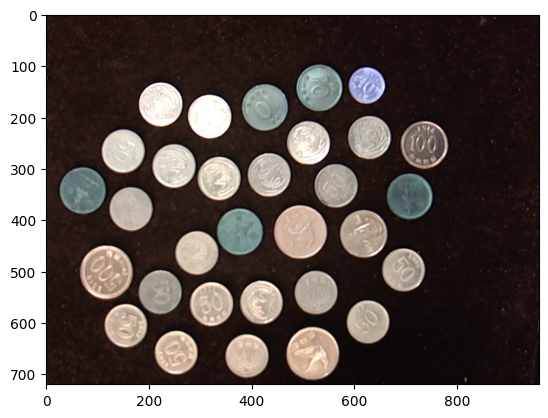

In [1]:
import numpy as np, cv2, time
import matplotlib.pyplot as plt

fname = '65.png'
img = cv2.imread(fname)
plt.imshow(img)

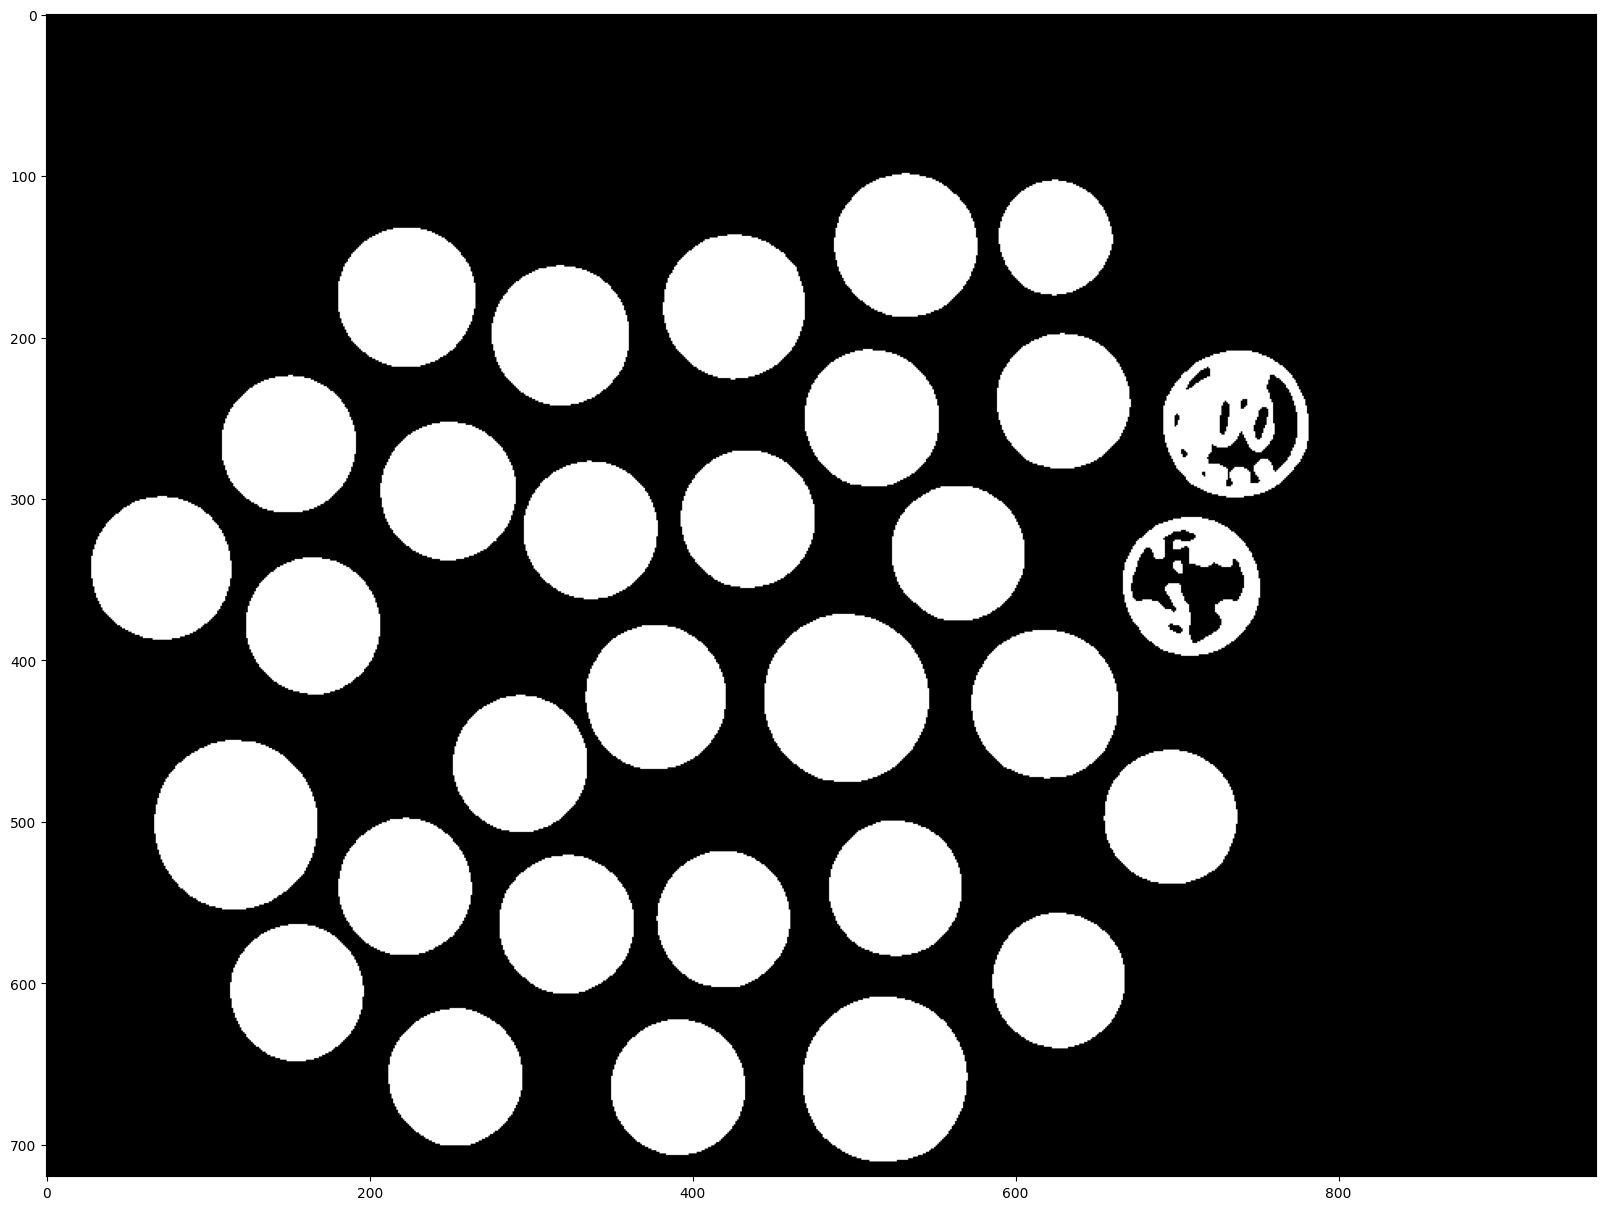

In [7]:
import numpy as np, cv2, time
import matplotlib.pyplot as plt

def preprocessing(coin_no):
    fname = f'{coin_no}.png'
    image = cv2.imread(fname, cv2.IMREAD_COLOR)
    if image is None:
        print('Image load failed!')
        return None, None  # None이 2개인 이유는 image와 th_img를 함께 반환하기 위함
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 가우시안 블러를 이용해 노이즈 제거, x, y 방향으로 7x7 크기의 커널을 사용, x, y 방향으로 2씩 표준편차를 사용
    gray = cv2.GaussianBlur(gray, (7, 7), 2, 2)
    # otsu 알고리즘을 이용해 최적의 임계값을 찾아 이진화 수행
    # otsu 알고리즘은 전체 이미지의 히스토그램을 분석하여 전경과 배경의 분산을 최대화하는 임계값을 찾아줌(사용자가 입력한 임계값 무시)
    flag = cv2.THRESH_BINARY + cv2.THRESH_OTSU
    _, th_img = cv2.threshold(gray, 130, 255, flag) # 임계값 130을 사용, 임계값보다 크면 255, 작으면 0, flag는 otsu 알고리즘 사용 입력 무시
    mask = np.ones((3,3), np.uint8)
    # 이진화된 이미지에서 작은 노이즈를 제거하기 위해 모폴로지 연산을 수행, 떨어져있는 객체를 더 명확하게 분리하기 위해 사용
    th_img = cv2.morphologyEx(th_img, cv2.MORPH_OPEN, mask) # morph_open은 침식 후 팽창 연산을 수행
    return image, th_img

image, th_img = preprocessing(65)
if image is None: raise Exception('Image load failed!')

plt.figure(figsize=(20, 16))
plt.imshow(cv2.cvtColor(th_img, cv2.COLOR_BGR2RGB))

In [8]:
!cv2.__version__

'cv2.__version__'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


OpenCV의 버전에 따라 cv2.findContours() 함수의 반환 값이 달라집니다.

- OpenCV 4.x: 반환 값은 (윤곽선 리스트, 계층 구조)로 되어 있으며, results[0]이 윤곽선 리스트입니다.
- OpenCV 3.x: 반환 값은 (수정된 이미지, 윤곽선 리스트)이며, 윤곽선 리스트는 results[1]입니다.

coin image


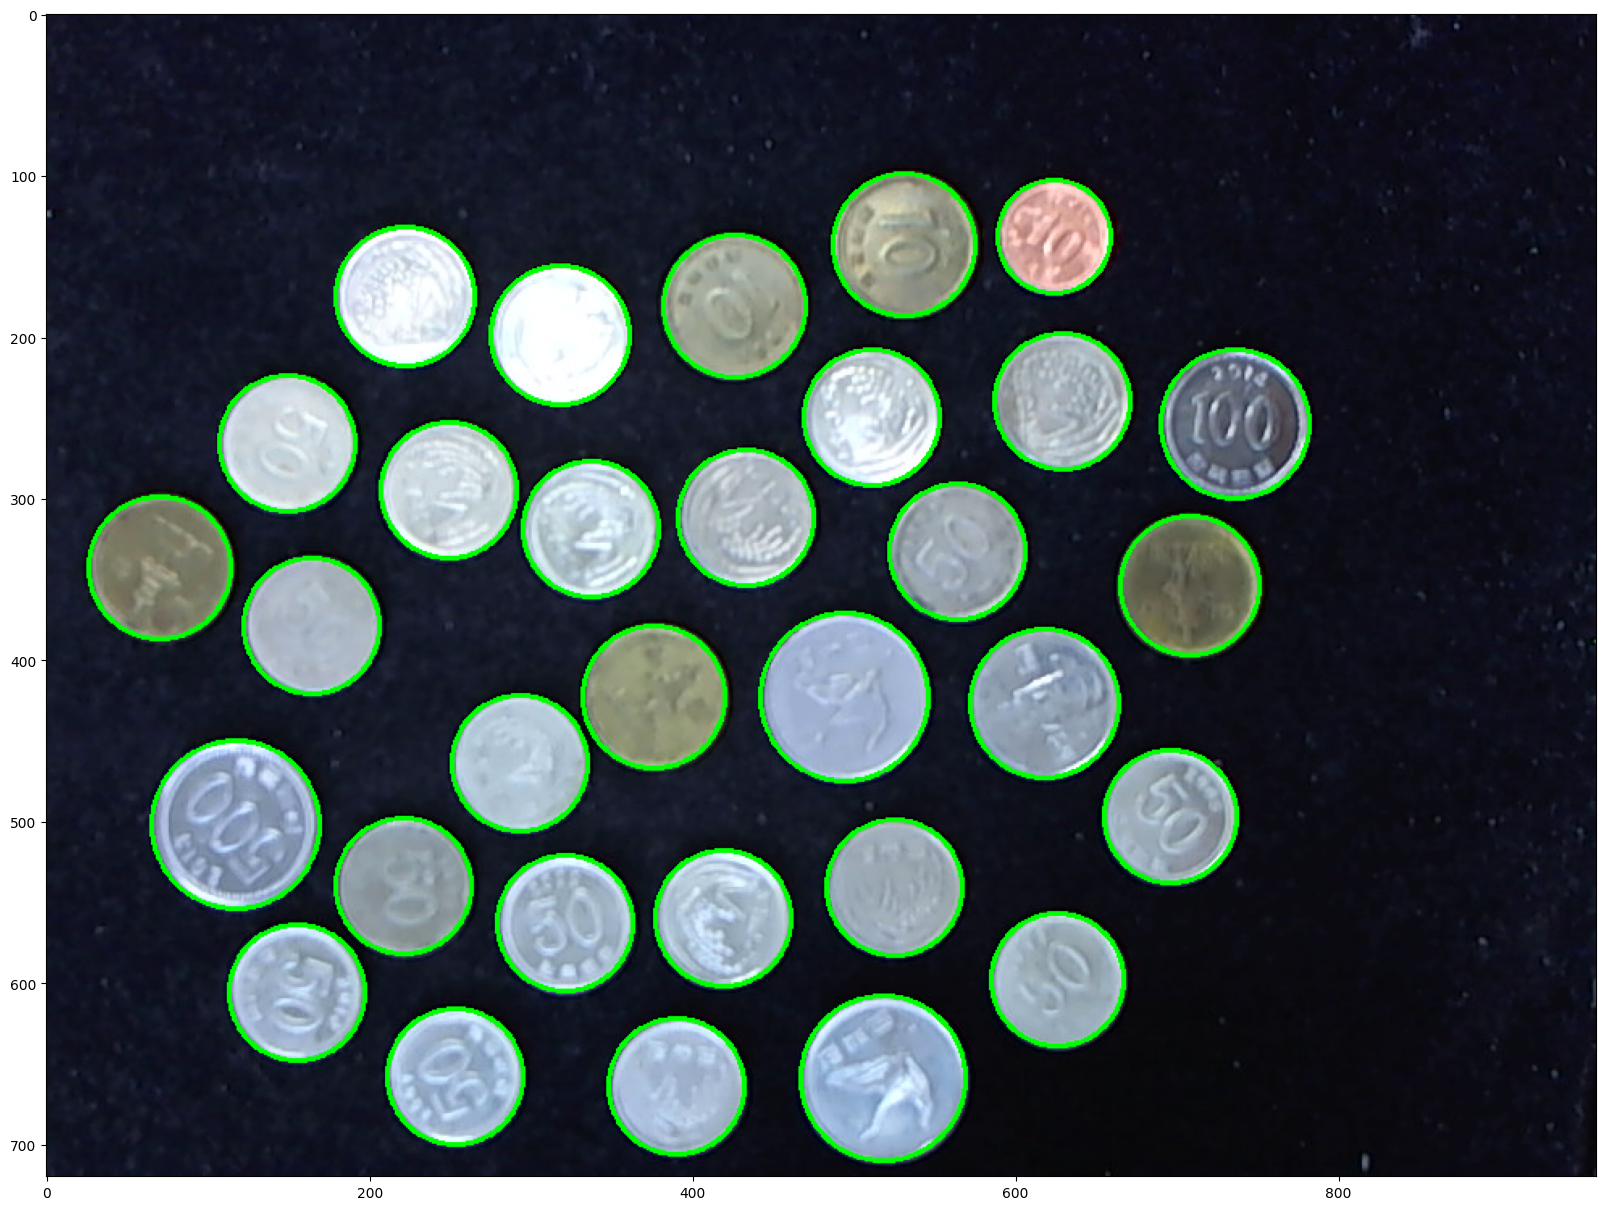

In [9]:
def find_coins(image):
    # cv2.findContours() 함수는 이진화된 이미지에서 윤곽선을 찾아 반환
    # cv2.RETR_EXTERNAL: 이미지의 가장 바깥쪽의 윤곽선만 찾음
    # cv2.CHAIN_APPROX_SIMPLE: 윤곽선을 그릴 수 있는 최소한의 점만 저장
    results = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = results[0] if int(cv2.__version__[0]) >= 4 else results[1]
    circles = [cv2.minEnclosingCircle(c) for c in contours]  # 최소 경계 원을 찾아줌
    circles = [(tuple(map(int, center)), int(radius)) for center, radius in circles if radius > 25]
    return circles

circles = find_coins(th_img)
for center, radius in circles:
    cv2.circle(image, center, radius, (0, 255, 0), 2) # 동전 영상 원으로 표시

print("coin image")
plt.figure(figsize=(20, 16))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

- 마스크 생성: 각 동전의 중심과 반지름을 기준으로 흰색 원이 그려진 검정색 마스크를 생성합니다.
- 동전 영역 추출: 원본 이미지에서 해당 동전이 위치한 사각형 영역을 추출합니다.
- 비트 연산: 마스크를 사용하여 동전 부분만 남기고 나머지 부분은 제거합니다.
- 결과 출력: 마스크가 적용된 최종 동전 이미지를 출력합니다.

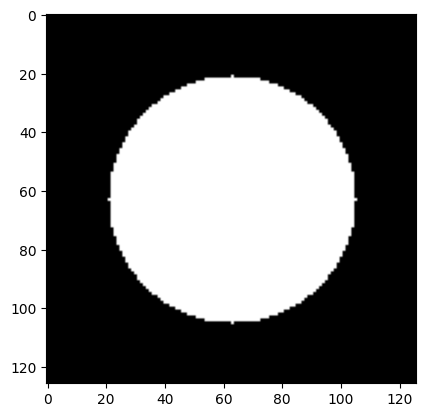

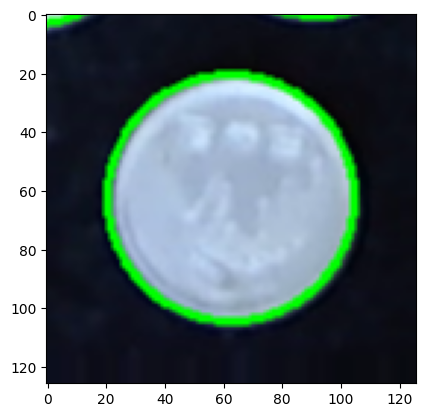

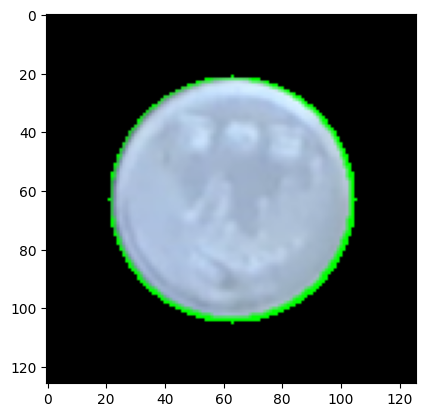

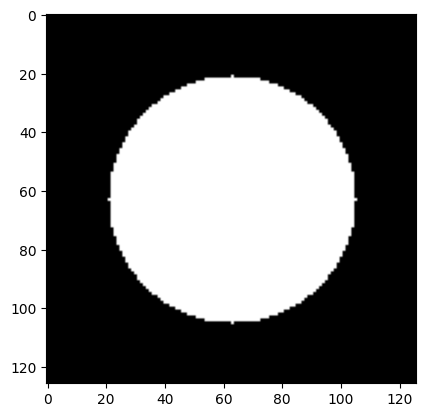

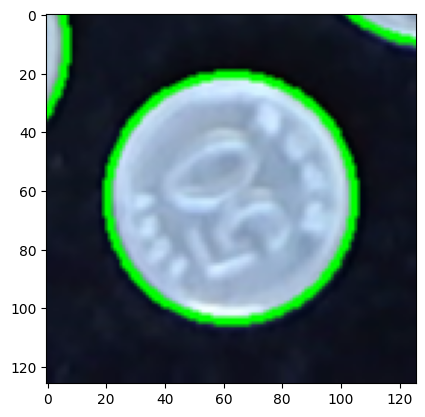

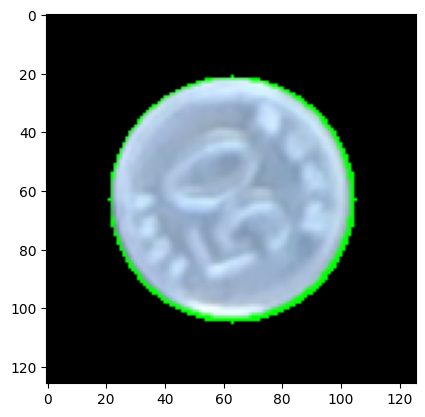

In [12]:
for center, radius in circles[0:2]:
    r = radius * 3
    cen = (r //2, r //2) # 중심 좌표 설정
    mask = np.zeros((r, r, 3), np.uint8) # (r, r, 3) 크기의 검은색 이미지 생성
    cv2.circle(mask, cen, radius, (255, 255, 255), cv2.FILLED)
    plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    plt.show()
    print()
    coin = cv2.getRectSubPix(image, (r, r), center)
    plt.imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))
    plt.show()
    print() 
    # 마스크의 흰색 영역은 동전의 픽셀값을 그대로 유지 (x AND 255 = x)(x AND 1 = x)
    # 마스크의 검은색 영역은 동전의 픽셀값을 0으로 변경하여 검은색으로 만듦(x AND 0 = 0)
    coin = cv2.bitwise_and(coin, mask)
    plt.imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB))
    plt.show()
    print()

In [13]:
def make_coin_img(src, circle):
    coins = []
    for center, radius in circle:
        r = radius * 3 # 검출 동전 반지름의 3배, 동전을 추출하는 과정에서 동전 영상이 온전히 포함되도록 하기 위함
        cen = (r //2, r //2) # 중심 좌표 설정
        mask = np.zeros((r, r, 3), np.uint8) # 마스크 생성
        cv2.circle(mask, cen, radius, (255, 255, 255), cv2.FILLED) # 채우기 옵션을 이용해 동전 영역을 흰색으로 채움
        coin = cv2.getRectSubPix(src, (r, r), center) # 동전이 위치한 사각형 영역을 추출
        coin = cv2.bitwise_and(coin, mask)
        coins.append(coin)
        # plt.imshow(cv2.cvtColor(coin, cv2.COLOR_BGR2RGB)) # 동전 영상 출력
    return coins


각 동전의 HSV 색상 히스토그램을 계산하는 과정을 수행

In [14]:
def calc_histo_hue(coin):
    hsv = cv2.cvtColor(coin, cv2.COLOR_BGR2HSV) # BGR을 HSV로 변환
    hsize, ranges = [32], [0, 180] # Hue 채널의 크기와 범위 설정
    hist = cv2.calcHist([hsv], [0], None, hsize, ranges) # Hue 채널에 대한 히스토그램 계산 0은 이미지의 첫 번째 채널, hue 의미, None은 마스크 사용 안함, hsize는 히스토그램 크기, ranges는 히스토그램 범위 bin수
    return hist.flatten() # 1차원 배열로 변환하여 반환

색상 팔레트 생성 함수 (make_palette)

In [15]:
# 주어진 행의 수에 대응하는 색상 팔레트 생성, bgr색상 공간으로 변환하는 과정을 구현
def make_palate(rows):
    hue = [round(i * 180 / rows) for i in range(rows)] # Hue 채널의 값을 rows 개수만큼 생성
    hsv = [[[h, 255, 255]] for h in hue] # Hue, Saturation, Value를 리스트로 생성
    hsv = np.array(hsv, np.uint8) # numpy 배열로 변환
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR) # HSV를 BGR로 변환하여 반환


히스토그램 계산 및 시각화
